# Исследование архитектур cверточных нейронных сетей на датасетах MNIST и CIFAR

Дисциплина: "**Системы поддержки принятия решений**"

**Подготовил**: Лосев А. П., гр. ИСТ-131м.

**Принял**: к.т.н., доцент кафедры ИУС, Литвинов В. Л.

## Анализ датасета MNIST

Импорт необходимых зависимостей и инициализация *random seed*:

In [1]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

Импорт встроенных наборов для обучения:

In [2]:
import torchvision.datasets

Загрузка датасетов MNIST для обучения и валидации результатов:

In [3]:
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

Размещение загруженных датасетов в переменные:

In [4]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

C:\Users\Arseniy Losev\.conda\envs\SPPR_working\lib\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\Users\Arseniy Losev\.conda\envs\SPPR_working\lib\site-packages\torchvision\datasets\mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
C:\Users\Arseniy Losev\.conda\envs\SPPR_working\lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\Users\Arseniy Losev\.conda\envs\SPPR_working\lib\site-packages\torchvision\datasets\mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Вывод информации о количестве индивидуальных единиц данных в датасетах:

In [5]:
len(y_train), len(y_test)

(60000, 10000)

Представление данных в датасете через числа с плавающей точкой для удобства манипулирования:

In [6]:
X_train = X_train.float()
X_test = X_test.float()

Вывод на график единичного изображения цифры из набора для обучения:

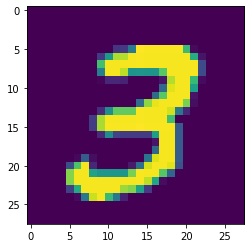

tensor(3)


In [7]:
import matplotlib.pyplot as plt
plt.imshow(X_train[7, :, :])
plt.show()
print(y_train[7])

Представление изображений из датасета как трёхмерных тензоров:

In [8]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

Вывод информации о размерности набора данных для обучения, где указано количество изображений (**60000**) и размерность тензора изображения (**1x28x28**):

In [9]:
X_train.shape

torch.Size([60000, 1, 28, 28])

Создание модели нейронной сети для датасета MNIST по подобию с сетью ЛеКуна при помощи наследования от класса *Module*:

In [10]:
class LeNet5(torch.nn.Module):
    def __init__(self,
                 activation='tanh',
                 pooling='avg',
                 conv_size=5,
                 use_batch_norm=False):
        super(LeNet5, self).__init__()
        
        self.conv_size = conv_size
        self.use_batch_norm = use_batch_norm
        
        if activation == 'tanh':
            activation_function = torch.nn.Tanh()
        elif activation == 'relu':
            activation_function  = torch.nn.ReLU()
        else:
            raise NotImplementedError
            
        if pooling == 'avg':
            pooling_layer = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        elif pooling == 'max':
            pooling_layer  = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        else:
            raise NotImplementedError
        
        if conv_size == 5:
            self.conv1 = torch.nn.Conv2d(
                in_channels=1, out_channels=6, kernel_size=5, padding=2)
        elif conv_size == 3:
            self.conv1_1 = torch.nn.Conv2d(
                in_channels=1, out_channels=6, kernel_size=3, padding=1)
            self.conv1_2 = torch.nn.Conv2d(
                in_channels=6, out_channels=6, kernel_size=3, padding=1)
        else:
            raise NotImplementedError

        self.act1 = activation_function
        self.bn1 = torch.nn.BatchNorm2d(num_features=6)
        self.pool1 = pooling_layer
       
        if conv_size == 5:
            self.conv2 = self.conv2 = torch.nn.Conv2d(
                in_channels=6, out_channels=16, kernel_size=5, padding=0)
        elif conv_size == 3:
            self.conv2_1 = torch.nn.Conv2d(
                in_channels=6, out_channels=16, kernel_size=3, padding=0)
            self.conv2_2 = torch.nn.Conv2d(
                in_channels=16, out_channels=16, kernel_size=3, padding=0)
        else:
            raise NotImplementedError

        self.act2 = activation_function
        self.bn2 = torch.nn.BatchNorm2d(num_features=16)
        self.pool2 = pooling_layer
        
        self.fc1 = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3 = activation_function
    
        self.fc2 = torch.nn.Linear(120, 84)
        self.act4 = activation_function
        
        self.fc3 = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        if self.conv_size == 5:
            x = self.conv1(x)
        elif self.conv_size == 3:
            x = self.conv1_2(self.conv1_1(x))
        x = self.act1(x)
        if self.use_batch_norm:
            x = self.bn1(x)
        x = self.pool1(x)
        
        if self.conv_size == 5:
            x = self.conv2(x)
        elif self.conv_size == 3:
            x = self.conv2_2(self.conv2_1(x))
        x = self.act2(x)
        if self.use_batch_norm:
            x = self.bn2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x

Обучение нейронной сети на тестовом наборе данных:

In [11]:
def train(net, X_train, y_train, X_test, y_test):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3)
    
    batch_size = 100

    test_accuracy_history = []
    test_loss_history = []

    X_test = X_test.to(device)
    y_test = y_test.to(device)

    for epoch in range(30):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            net.train()

            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            preds = net.forward(X_batch) 

            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()

        net.eval()
        with torch.no_grad(): 
             test_preds = net.forward(X_test)
            
             test_loss_history.append(loss(test_preds, y_test).data.cpu())
        accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
        test_accuracy_history.append(accuracy)

        print(accuracy)
    print('---------------')
    return test_accuracy_history, test_loss_history

accuracies = {}
losses = {}


accuracies['tanh'], losses['tanh'] = \
    train(LeNet5(activation='tanh', conv_size=5),
          X_train, y_train, X_test, y_test)

accuracies['relu'], losses['relu'] = \
    train(LeNet5(activation='relu', conv_size=5),
          X_train, y_train, X_test, y_test)

accuracies['relu_3'], losses['relu_3'] = \
    train(LeNet5(activation='relu', conv_size=3),
          X_train, y_train, X_test, y_test)

accuracies['relu_3_max_pool'], losses['relu_3_max_pool'] = \
    train(LeNet5(activation='relu', conv_size=3, pooling='max'), 
          X_train, y_train, X_test, y_test)

accuracies['relu_3_max_pool_bn'], losses['relu_3_max_pool_bn'] = \
    train(LeNet5(activation='relu', conv_size=3, pooling='max', use_batch_norm=True), 
          X_train, y_train, X_test, y_test)

tensor(0.9761)
tensor(0.9826)
tensor(0.9868)
tensor(0.9873)
tensor(0.9877)
tensor(0.9876)
tensor(0.9889)
tensor(0.9862)
tensor(0.9880)
tensor(0.9879)
tensor(0.9886)
tensor(0.9904)
tensor(0.9871)
tensor(0.9878)
tensor(0.9899)
tensor(0.9888)
tensor(0.9898)
tensor(0.9891)
tensor(0.9889)
tensor(0.9861)
tensor(0.9876)
tensor(0.9888)
tensor(0.9878)
tensor(0.9873)
tensor(0.9895)
tensor(0.9891)
tensor(0.9878)
tensor(0.9883)
tensor(0.9906)
tensor(0.9893)
---------------
tensor(0.9814)
tensor(0.9863)
tensor(0.9889)
tensor(0.9894)
tensor(0.9892)
tensor(0.9902)
tensor(0.9885)
tensor(0.9886)
tensor(0.9861)
tensor(0.9879)
tensor(0.9893)
tensor(0.9887)
tensor(0.9894)
tensor(0.9917)
tensor(0.9904)
tensor(0.9874)
tensor(0.9900)
tensor(0.9899)
tensor(0.9902)
tensor(0.9905)
tensor(0.9909)
tensor(0.9913)
tensor(0.9881)
tensor(0.9893)
tensor(0.9893)
tensor(0.9884)
tensor(0.9901)
tensor(0.9912)
tensor(0.9874)
tensor(0.9905)
---------------
tensor(0.9782)
tensor(0.9878)
tensor(0.9871)
tensor(0.9830)
tensor(0

Графическая репрезентация точности прогнозирования:

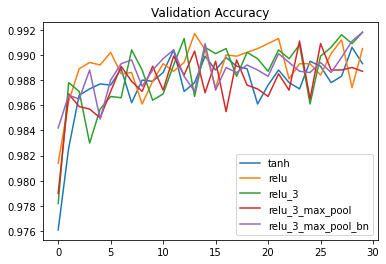

In [12]:
Графическая репрезентация точности прогнозирования:for experiment_id in accuracies.keys():
    plt.plot(accuracies[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Accuracy');

Графическая репрезентация функции потерь:

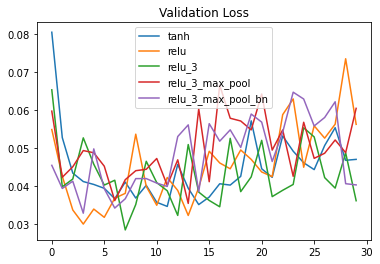

In [13]:
for experiment_id in losses.keys():
    plt.plot(losses[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Loss');

## Анализ датасета CIFAR

Импорт необходимых зависимостей и инициализация *random seed*:

In [14]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

Импорт встроенных наборов для обучения:

In [15]:
import torchvision.datasets

Загрузка датасетов CIFAR для обучения и валидации результатов:

In [16]:
CIFAR_train = torchvision.datasets.CIFAR10('./', download=True, train=True)
CIFAR_test = torchvision.datasets.CIFAR10('./', download=True, train=False)

Files already downloaded and verified
Files already downloaded and verified


Размещение загруженных датасетов в переменные:

In [17]:
X_train = torch.FloatTensor(CIFAR_train.data)
y_train = torch.LongTensor(CIFAR_train.targets)
X_test = torch.FloatTensor(CIFAR_test.data)
y_test = torch.LongTensor(CIFAR_test.targets)

Вывод информации о количестве индивидуальных единиц данных в датасетах:

In [18]:
len(y_train), len(y_test)

(50000, 10000)

Вывод информации о максимальном и минимальном значении для изображений:

In [19]:
X_train.min(), X_train.max()

(tensor(0.), tensor(255.))

Деление значений в датасете на 255 для удобства манипулирования:

In [20]:
X_train /= 255.
X_test /= 255.

Вывод информации о классах изображений, используемых в датасете CIFAR:

In [21]:
CIFAR_train.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Вывод изображений из датасета CIFAR для визуальной оценки и сопоставления с номерами тензоров:

tensor(6) tensor(9) tensor(9) tensor(4) tensor(1) tensor(1) tensor(2) tensor(7) tensor(8) tensor(3) 

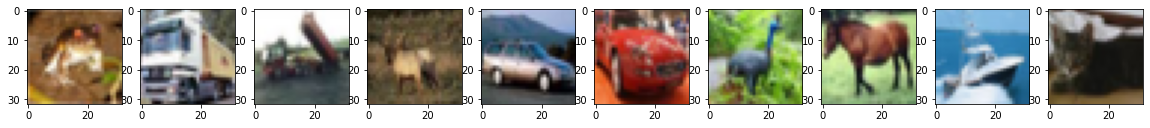

In [22]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(20,2)) 
for i in range(10): 
    plt.subplot(1, 10, i+1) 
    plt.imshow(X_train[i]) 
    print(y_train[i], end=' ')

Вывод информации о размерности набора данных для обучения, где указано количество изображений (**50000**) и размерность тензора изображения (**32x32x3**):

In [23]:
X_train.shape, y_train.shape

(torch.Size([50000, 32, 32, 3]), torch.Size([50000]))

Перестановка последовательности информации в тензоре для удобства работы (первоочерёдно — каналы цвета (**3**), после — размерность изображения(**32x32**)):

In [24]:
X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)

Вывод информации о размерности набора данных для обучения, где указано количество изображений (**50000**) и размерность тензора изображения (**3x32x32**):

In [25]:
X_train.shape

torch.Size([50000, 3, 32, 32])

Создание модели нейронной сети для датасета MNIST по подобию с сетью ЛеКуна при помощи наследования от класса *Module*:

In [26]:
class LeNet5(torch.nn.Module):
    def __init__(self,
                 activation='tanh',
                 pooling='avg',
                 conv_size=5, 
                 use_batch_norm=False):
        super(LeNet5, self).__init__()
        
        self.conv_size = conv_size
        self.use_batch_norm = use_batch_norm
        
        if activation == 'tanh':
            activation_function = torch.nn.Tanh()
        elif activation == 'relu':
            activation_function  = torch.nn.ReLU()
        else:
            raise NotImplementedError
            
        if pooling == 'avg':
            pooling_layer = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        elif pooling == 'max':
            pooling_layer  = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        else:
            raise NotImplementedError
        
        if conv_size == 5:
            self.conv1 = torch.nn.Conv2d(
                in_channels=3, out_channels=6, kernel_size=5, padding=0)
        elif conv_size == 3:
            self.conv1_1 = torch.nn.Conv2d(
                in_channels=3, out_channels=6, kernel_size=3, padding=0)
            self.conv1_2 = torch.nn.Conv2d(
                in_channels=6, out_channels=6, kernel_size=3, padding=0)
        else:
            raise NotImplementedError

        self.act1 = activation_function
        self.bn1 = torch.nn.BatchNorm2d(num_features=6)
        self.pool1 = pooling_layer
       
        if conv_size == 5:
            self.conv2 = self.conv2 = torch.nn.Conv2d(
                in_channels=6, out_channels=16, kernel_size=5, padding=0)
        elif conv_size == 3:
            self.conv2_1 = torch.nn.Conv2d(
                in_channels=6, out_channels=16, kernel_size=3, padding=0)
            self.conv2_2 = torch.nn.Conv2d(
                in_channels=16, out_channels=16, kernel_size=3, padding=0)
        else:
            raise NotImplementedError

        self.act2 = activation_function
        self.bn2 = torch.nn.BatchNorm2d(num_features=16)
        self.pool2 = pooling_layer
        
        self.fc1 = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3 = activation_function
    
        self.fc2 = torch.nn.Linear(120, 84)
        self.act4 = activation_function
        
        self.fc3 = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        if self.conv_size == 5:
            x = self.conv1(x)
        elif self.conv_size == 3:
            x = self.conv1_2(self.conv1_1(x))
        x = self.act1(x)
        if self.use_batch_norm:
            x = self.bn1(x)
        x = self.pool1(x)
        
        if self.conv_size == 5:
            x = self.conv2(x)
        elif self.conv_size == 3:
            x = self.conv2_2(self.conv2_1(x))
        x = self.act2(x)
        if self.use_batch_norm:
            x = self.bn2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x

Обучение нейронной сети на тестовом наборе данных:

In [28]:
def train(net, X_train, y_train, X_test, y_test):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3)
    
    batch_size = 100

    test_accuracy_history = []
    test_loss_history = []

    X_test = X_test.to(device)
    y_test = y_test.to(device)

    for epoch in range(30):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            net.train()

            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            preds = net.forward(X_batch)

            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()
            
            X_batch

        net.eval()
        with torch.no_grad():
             test_preds = net.forward(X_test)

        test_loss_history.append(loss(test_preds, y_test).data.cpu())

        accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
        test_accuracy_history.append(accuracy)

        print(accuracy)
    del net
    print('---------------')
    return test_accuracy_history, test_loss_history

accuracies = {}
losses = {}

accuracies['tanh'], losses['tanh'] = \
    train(LeNet5(activation='tanh', conv_size=5),
          X_train, y_train, X_test, y_test)
accuracies['relu'], losses['relu'] = \
    train(LeNet5(activation='relu', conv_size=5),
          X_train, y_train, X_test, y_test)
accuracies['relu_3'], losses['relu_3'] = \
    train(LeNet5(activation='relu', conv_size=3),
          X_train, y_train, X_test, y_test)
accuracies['relu_3_max_pool'], losses['relu_3_max_pool'] = \
    train(LeNet5(activation='relu', conv_size=3, pooling='max'), 
          X_train, y_train, X_test, y_test)
accuracies['relu_3_max_pool_bn'], losses['relu_3_max_pool_bn'] = \
    train(LeNet5(activation='relu', conv_size=3, pooling='max', use_batch_norm=True), 
          X_train, y_train, X_test, y_test)

tensor(0.3856)
tensor(0.4370)
tensor(0.4724)
tensor(0.5005)
tensor(0.5135)
tensor(0.5224)
tensor(0.5338)
tensor(0.5333)
tensor(0.5464)
tensor(0.5474)
tensor(0.5497)
tensor(0.5473)
tensor(0.5511)
tensor(0.5458)
tensor(0.5535)
tensor(0.5463)
tensor(0.5488)
tensor(0.5495)
tensor(0.5470)
tensor(0.5512)
tensor(0.5438)
tensor(0.5487)
tensor(0.5406)
tensor(0.5490)
tensor(0.5456)
tensor(0.5435)
tensor(0.5435)
tensor(0.5465)
tensor(0.5457)
tensor(0.5455)
---------------
tensor(0.3613)
tensor(0.4352)
tensor(0.4620)
tensor(0.4925)
tensor(0.5036)
tensor(0.5244)
tensor(0.5309)
tensor(0.5389)
tensor(0.5381)
tensor(0.5432)
tensor(0.5570)
tensor(0.5509)
tensor(0.5553)
tensor(0.5674)
tensor(0.5695)
tensor(0.5726)
tensor(0.5683)
tensor(0.5747)
tensor(0.5782)
tensor(0.5760)
tensor(0.5712)
tensor(0.5804)
tensor(0.5817)
tensor(0.5750)
tensor(0.5821)
tensor(0.5785)
tensor(0.5865)
tensor(0.5806)
tensor(0.5894)
tensor(0.5922)
---------------
tensor(0.4142)
tensor(0.4686)
tensor(0.4966)
tensor(0.5287)
tensor(0

Графическая репрезентация точности прогнозирования:

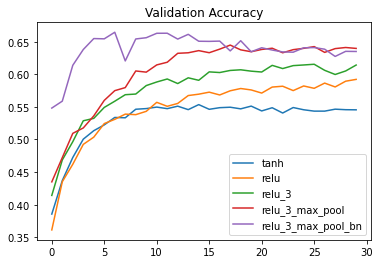

In [29]:
for experiment_id in accuracies.keys():
    plt.plot(accuracies[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Accuracy');

Графическая репрезентация функции потерь:

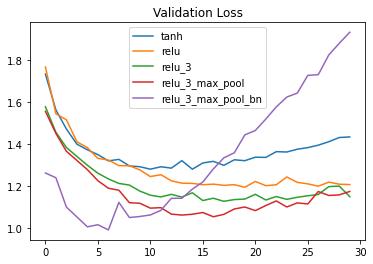

In [31]:
for experiment_id in losses.keys():
    plt.plot(losses[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Loss');

***
**Задание на лабораторную работу**
***

1. Изучить понятия: **батч-нормализация**, **переобучение нейронной сети**;
2. Исследовать нейронную сеть LeNet при различных параметрах (5 вариантов) на датасете MNIST. Объяснить результаты экспериментов;
3.	Исследовать нейронную сеть LeNet при различных параметрах (5 вариантов) на датасете CIFAR. Построить графики validation loss. Объяснить результаты экспериментов. Каким образом можно избежать переобучения сети?

***
**Ответы на задание**
***

1. **Батч-нормализация** — процесс оптимизации процесса обучения нейронной сети, заключающийся в расчёте градиента функции потерь для оптимизации алгоритма обратного распространения ошибки. **Переобучение нейронной сети** — результат процесса обучения, при котором нейронная сеть показывает качественные результаты распознавания на объектах из обучающей выборки, однако не способна обеспечить столь же качественные результаты с внешними данными.
2. Нейронная сеть LeNet была исследована на датасете MNIST, полученные результаты для точности и функции потерь представлены на графиках. Наиболее удачные результаты дала функция активации **relu_3_max_pool_bn**.
3. Нейронная сеть LeNet была исследована на датасете CIFAR, полученные результаты для точности и функции потерь представлены на графиках. Наиболее удачные результаты дала функция активации **relu_3_max_pool**.

**Выводы**: при выполнении лабораторной работы были получены практические навыки работы со свёрточной нейронной сетью при анализе датасета с цветными изображениями. Также были рассмотренны такие понятия, как батч-нормализация и переобучение нейронной сети.